# Runing multi-NichenetR to connect ligands and targets

In [ ]:
## In order to focus on specific cell types, trying to identify deg for each cell type between AD and control 
## and check if there is any link between ligand and targeted genes
# Andi Liu

# loading
suppressPackageStartupMessages({
library(Seurat)
library(Signac)
library(dplyr)
library(patchwork)
library(ggplot2)
library(future)
library(stringr)
library(tidydr)
library(RColorBrewer)
library(cowplot)
library(ggpubr)
library(tidyverse)
library(SingleCellExperiment)
library(dplyr)
library(ggplot2)
library(nichenetr)
library(multinichenetr)
})

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.3”
Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.3.3”
Warning message:
“package ‘S4Vectors’ was built under R version 4.3.3”
Warning message:
“package ‘IRanges’ was built under R version 4.3.3”
Warning message:
“package ‘Biobase’ was built under R version 4.3.3”


In [3]:
gc()
#### process the results
pfc <- readRDS("cellbender_PFC_object_10.31.rds")
hip <- readRDS("cellbender_HIP_object_10.31.rds")
ec <- readRDS("cellbender_EC_object_10.31.rds")

pfc
ec
hip
ls()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12532674,669.4,19662668,1050.1,15560786,831.1
Vcells,23581386,180.0,37389395,285.3,26119079,199.3


An object of class Seurat 
744833 features across 26963 samples within 7 assays 
Active assay: CTpeaks (317963 features, 317963 variable features)
 2 layers present: counts, data
 6 other assays present: RNA, ATAC, PC, SCT, peaks, chromvar
 15 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, wnn.umap, harmony.rna, harmony.rna.umap, harmony.atac, harmony.atac.umap, umap.CTpeaks, harmony.CTpeaks, harmony.CTpeaks.umap, umap.peaks, harmony.peaks, harmony.peaks.umap

An object of class Seurat 
744833 features across 23793 samples within 7 assays 
Active assay: CTpeaks (317963 features, 317963 variable features)
 2 layers present: counts, data
 6 other assays present: RNA, ATAC, PC, SCT, peaks, chromvar
 15 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, wnn.umap, harmony.rna, harmony.rna.umap, harmony.atac, harmony.atac.umap, umap.CTpeaks, harmony.CTpeaks, harmony.CTpeaks.umap, umap.peaks, harmony.peaks, harmony.peaks.umap

An object of class Seurat 
744833 features across 25417 samples within 7 assays 
Active assay: CTpeaks (317963 features, 317963 variable features)
 2 layers present: counts, data
 6 other assays present: RNA, ATAC, PC, SCT, peaks, chromvar
 15 dimensional reductions calculated: pca, umap.rna, lsi, umap.atac, wnn.umap, harmony.rna, harmony.rna.umap, harmony.atac, harmony.atac.umap, umap.CTpeaks, harmony.CTpeaks, harmony.CTpeaks.umap, umap.peaks, harmony.peaks, harmony.peaks.umap

[1] "ec"  "hip" "pfc"

In [12]:
organism = "human"
options(timeout = 120)
  lr_network_all = readRDS(url("https://zenodo.org/record/10229222/files/lr_network_human_allInfo_30112033.rds")) %>% 
    mutate(
      ligand = convert_alias_to_symbols(ligand, organism = organism), 
      receptor = convert_alias_to_symbols(receptor, organism = organism))
  
  lr_network_all = lr_network_all  %>% 
    mutate(ligand = make.names(ligand), receptor = make.names(receptor)) 
  
  lr_network = lr_network_all %>% 
    distinct(ligand, receptor)
  
  ligand_target_matrix = readRDS(url(
    "https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"
    ))
  
  colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% 
    convert_alias_to_symbols(organism = organism) %>% make.names()
  rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% 
    convert_alias_to_symbols(organism = organism) %>% make.names()
  
  lr_network = lr_network %>% filter(ligand %in% colnames(ligand_target_matrix))
  ligand_target_matrix = ligand_target_matrix[, lr_network$ligand %>% unique()]


[1] "following are the official gene symbols of input aliases: "
  symbol alias
1  YARS1  YARS
[1] "all input symbols were official symbols"
[1] "all input symbols were official symbols"
[1] "all input symbols were official symbols"


In [5]:
Idents(pfc) <- "cluster_celltype"
Idents(ec) <- "cluster_celltype"
Idents(hip) <- "cluster_celltype"

In [ ]:
## WORKING on each region
## keeping selected celltypes
obj <- subset(x = ec, idents = c("Astrocyte", "Excitatory","Inhibitory","Microglia","Oligodendrocyte","OPC"))
obj$cluster_celltype <- as.character(obj$cluster_celltype)

In [61]:
## convert seurat object into sec object
sce = Seurat::as.SingleCellExperiment(obj, assay = "PC")
sce = alias_to_symbol_SCE(sce, "human") %>% makenames_SCE()

## setting variates
sample_id = "individual_ID"
group_id = "diagnosis"
celltype_id = "cluster_celltype"
covariates = NA
batches = NA

## filter the cell type of interest
senders_oi = SummarizedExperiment::colData(sce)[,celltype_id] %>% unique()
receivers_oi = SummarizedExperiment::colData(sce)[,celltype_id] %>% unique()
## excluding rare cell type in the object
sce = sce[, SummarizedExperiment::colData(sce)[,celltype_id] %in% c(senders_oi, receivers_oi)]
sce

[1] "all input symbols were official symbols"


class: SingleCellExperiment 
dim: 14927 25383 
metadata(0):
assays(3): counts logcounts scaledata
rownames(14927): NOC2L KLHL17 ... NCBP2L SLFN12L
rowData names(0):
colnames(25383): NIH03_TACTGGCCAGGTCCTG-1 NIH03_GCCATGATCTTGAGGT-1 ...
  NIH30_TAAGCCTAGGCGAAAC-1 NIH30_GAACACAAGTTGTCAA-1
colData names(49): orig.ident nCount_RNA ... RIN ident
reducedDimNames(15): PCA UMAP.RNA ... HARMONY.PEAKS HARMONY.PEAKS.UMAP
mainExpName: PC
altExpNames(0):

In [62]:
# set case anc control
contrasts_oi = c("'EOAD-NCI','NCI-EOAD'")
contrast_tbl = tibble(contrast =
                        c("EOAD-NCI", "NCI-EOAD"),
                      group = c("EOAD", "NCI"))

In [63]:
### quality control procedures for the selected region
min_cells = 10
min_sample_prop = 0.50
empirical_pval = FALSE

## using default parameters
# using nominal p values because of small sample size
logFC_threshold = 0.75
p_val_threshold = 0.05
fraction_cutoff = 0.25

# if using adjusted p value
p_val_adj = FALSE
top_n_target = 250
verbose = TRUE
#cores_system = 12
n.cores = 12
#n.cores = min(cores_system, sender_receiver_de$receiver %>% unique() %>% length())
# prioritization
scenario = "regular"
ligand_activity_down = FALSE

In [64]:
multinichenet_output = multi_nichenet_analysis(
  sce = sce, 
  celltype_id = celltype_id, sample_id = sample_id, group_id = group_id, 
  batches = batches, covariates = covariates, 
  lr_network = lr_network, ligand_target_matrix = ligand_target_matrix, 
  contrasts_oi = contrasts_oi, contrast_tbl = contrast_tbl, 
  senders_oi = senders_oi, receivers_oi = receivers_oi,
  min_cells = min_cells, 
  fraction_cutoff = fraction_cutoff, 
  min_sample_prop = min_sample_prop,
  scenario = scenario, 
  ligand_activity_down = ligand_activity_down,
  logFC_threshold = logFC_threshold, 
  p_val_threshold = p_val_threshold, 
  p_val_adj = p_val_adj, 
  empirical_pval = empirical_pval, 
  top_n_target = top_n_target, 
  n.cores = n.cores, 
  verbose = TRUE
  )

[1] "Cell type & sample filtering"
[1] "condition-specific celltypes:"
character(0)
[1] "absent celltypes:"
character(0)
[1] "Gene filtering"


Joining with `by = join_by(sample, group)`


[1] "Samples are considered if they have more than 10 cells of the cell type of interest"


Joining with `by = join_by(sample, celltype)`


[1] "Genes with non-zero counts in at least 25% of cells of a cell type of interest in a particular sample will be considered as expressed in that sample."
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Astrocyte"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Excitatory"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Inhibitory"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Microglia"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: OPC"
[1] "Genes expressed in at least 2 samples will considered as expressed in the cell type: Oligodendrocyte"


Joining with `by = join_by(sample)`
Joining with `by = join_by(celltype)`
Joining with `by = join_by(sample, celltype, group)`


[1] "3408 genes are considered as expressed in the cell type: Astrocyte"
[1] "8248 genes are considered as expressed in the cell type: Excitatory"
[1] "8408 genes are considered as expressed in the cell type: Inhibitory"
[1] "1944 genes are considered as expressed in the cell type: Microglia"
[1] "3761 genes are considered as expressed in the cell type: OPC"
[1] "2109 genes are considered as expressed in the cell type: Oligodendrocyte"
[1] "Calculate normalized average and pseudobulk expression"


Joining with `by = join_by(sender, receiver, ligand, receptor)`
Joining with `by = join_by(sender, receiver, ligand, receptor)`
Joining with `by = join_by(sender, receiver, ligand, receptor)`


[1] "Calculate differential expression for all cell types"
[1] "DE analysis is done:"
[1] "included cell types are:"
[1] "Inhibitory"      "Excitatory"      "Oligodendrocyte" "Astrocyte"      
[5] "OPC"             "Microglia"      
[1] "retained cell types"
[1] "Inhibitory"      "Excitatory"      "Oligodendrocyte" "Astrocyte"      
[5] "OPC"             "Microglia"      
[1] "Calculate NicheNet ligand activities and ligand-target links"
[1] "Combine all the information in prioritization tables"
[1] "Calculate correlation between LR pairs and target genes"
[1] "There are no condition specific cell types in the data. MultiNicheNet analysis is performed in the regular way for all cell types."


In [65]:
## Save
saveRDS(multinichenet_output, "./Results/CCC/HIP_multinichenet_output_0.25.rds")

## Downstream analysis of the output

In [3]:
multinichenet_output <- readRDS("./Results/CCC/EC_multinichenet_output_0.25.rds")

### Modify the function a little bit for outputing the targeted genes

In [39]:
make_ligand_activity_target_plot = function (group_oi, receiver_oi, prioritized_tbl_oi, prioritization_tables, 
    ligand_activities_targets_DEgenes, contrast_tbl, grouping_tbl, 
    receiver_info, ligand_target_matrix, groups_oi = NULL, plot_legend = TRUE, 
    heights = NULL, widths = NULL) 
{
    requireNamespace("dplyr")
    requireNamespace("ggplot2")
    if (is.null(groups_oi)) {
        groups_oi = contrast_tbl %>% dplyr::pull(group) %>% unique()
    }
    best_upstream_ligands = prioritized_tbl_oi$ligand %>% unique()
    active_ligand_target_links_df = ligand_activities_targets_DEgenes$ligand_activities %>% 
        dplyr::ungroup() %>% dplyr::inner_join(contrast_tbl) %>% 
        dplyr::filter(ligand %in% best_upstream_ligands & receiver == 
            receiver_oi & group == group_oi) %>% dplyr::ungroup() %>% 
        dplyr::select(ligand, target, ligand_target_weight, direction_regulation) %>% 
        dplyr::rename(weight = ligand_target_weight)
    active_ligand_target_links_df = active_ligand_target_links_df %>% 
        dplyr::filter(!is.na(weight))
    if (active_ligand_target_links_df$target %>% unique() %>% 
        length() <= 2) {
        cutoff = 0
    }
    else {
        cutoff = 0.2
    }
    active_ligand_target_links = nichenetr::prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, 
        ligand_target_matrix = ligand_target_matrix, cutoff = cutoff)
    order_ligands_ = generics::intersect(best_upstream_ligands, 
        colnames(active_ligand_target_links)) %>% rev()
    order_targets_ = active_ligand_target_links_df$target %>% 
        unique() %>% generics::intersect(rownames(active_ligand_target_links))
    order_ligands = order_ligands_ %>% make.names()
    order_targets = order_targets_ %>% make.names()
    rownames(active_ligand_target_links) = rownames(active_ligand_target_links) %>% 
        make.names()
    colnames(active_ligand_target_links) = colnames(active_ligand_target_links) %>% 
        make.names()
    if (!is.matrix(active_ligand_target_links[order_targets, 
        order_ligands])) {
        vis_ligand_target = active_ligand_target_links[order_targets, 
            order_ligands] %>% matrix(ncol = 1)
        rownames(vis_ligand_target) = order_ligands
        colnames(vis_ligand_target) = order_targets
    }
    else {
        vis_ligand_target = active_ligand_target_links[order_targets, 
            order_ligands] %>% t()
    }
    vis_ligand_target_df = vis_ligand_target %>% data.frame() %>% 
        tibble::rownames_to_column("ligand") %>% tidyr::gather("target", 
        "score", -ligand) %>% tibble::as_tibble() %>% dplyr::mutate(ligand = factor(ligand, 
        levels = order_ligands)) %>% dplyr::inner_join(active_ligand_target_links_df %>% 
        distinct(target, direction_regulation)) %>% dplyr::mutate(target = factor(target, 
        levels = order_targets))
    p_ligand_target_network = vis_ligand_target_df %>% ggplot(aes(target, 
        ligand, fill = score)) + geom_tile(color = "whitesmoke", 
        size = 0.5) + facet_grid(. ~ direction_regulation, scales = "free", 
        space = "free") + scale_fill_gradient2(low = "white", 
        mid = "purple", high = "darkred", midpoint = 0.14) + 
        theme_light() + scale_x_discrete(position = "top") + 
        theme(axis.ticks = element_blank(), axis.title.x = element_text(size = 10), 
            axis.title.y = element_text(size = 10), axis.text.y = element_text(size = 9), 
            axis.text.x = element_text(size = 9, angle = 90, 
                hjust = 0, face = "italic"), strip.text.x.top = element_text(angle = 0), 
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
            panel.spacing.x = unit(0.5, "lines"), strip.text.x = element_text(size = 9, 
                color = "black"), strip.background = element_rect(color = "darkgrey", 
                fill = "whitesmoke", size = 1.5, linetype = "solid")) + 
        labs(fill = "Regulatory Potential") + xlab("Predicted target genes") + 
        ylab("Prioritized ligands")
    custom_scale_fill = scale_fill_gradientn(colours = c("white", 
        RColorBrewer::brewer.pal(n = 11, name = "PiYG") %>% .[1:5] %>% 
            rev()), values = c(0, 0.04, 0.12, 0.3, 0.4, 0.55, 
        1), limits = c(0, max(ligand_target_matrix)))
    p_ligand_target_network = p_ligand_target_network + custom_scale_fill
    ligand_activity_df = ligand_activities_targets_DEgenes$ligand_activities %>% 
        dplyr::ungroup() %>% dplyr::filter(ligand %in% order_ligands_ & 
        receiver == receiver_oi) %>% dplyr::inner_join(contrast_tbl) %>% 
        dplyr::filter(group %in% groups_oi) %>% dplyr::select(ligand, 
        group, direction_regulation, activity_scaled) %>% dplyr::distinct() %>% 
        dplyr::mutate(ligand = factor(ligand, levels = order_ligands))
    p_ligand_activity_scaled = ligand_activity_df %>% ggplot(aes(direction_regulation, 
        ligand, fill = activity_scaled)) + geom_tile(color = "whitesmoke") + 
        facet_grid(. ~ group, scales = "free", space = "free") + 
        scale_x_discrete(position = "top") + theme_light() + 
        theme(axis.ticks = element_blank(), axis.title.x = element_text(size = 10), 
            axis.title.y = element_text(size = 10), axis.text.y = element_text(size = 9), 
            axis.text.x = element_text(size = 9, angle = 90, 
                hjust = 0), strip.text.x.top = element_text(angle = 0), 
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
            panel.spacing.x = unit(0.5, "lines"), panel.spacing.y = unit(0.5, 
                "lines"), strip.text.x = element_text(size = 10, 
                color = "black"), strip.text.y = element_blank(), 
            strip.background = element_rect(color = "darkgrey", 
                fill = "whitesmoke", size = 1.5, linetype = "solid")) + 
        labs(fill = "Scaled Ligand\nActivity in Receiver") + 
        ylab("Prioritized ligands") + xlab("Scaled ligand activity")
    max_activity = abs(ligand_activity_df$activity_scaled) %>% 
        max(na.rm = TRUE)
    custom_scale_fill = scale_fill_gradientn(colours = c("white", 
        RColorBrewer::brewer.pal(n = 7, name = "PuRd") %>% .[-7]), 
        values = c(0, 0.51, 0.575, 0.625, 0.675, 0.725, 1), limits = c(-1 * 
            max_activity, max_activity))
    p_ligand_activity_scaled = p_ligand_activity_scaled + custom_scale_fill
    ligand_activity_df = ligand_activities_targets_DEgenes$ligand_activities %>% 
        dplyr::ungroup() %>% dplyr::filter(ligand %in% order_ligands_ & 
        receiver == receiver_oi) %>% dplyr::inner_join(contrast_tbl) %>% 
        dplyr::filter(group %in% groups_oi) %>% dplyr::select(ligand, 
        group, direction_regulation, activity) %>% dplyr::distinct() %>% 
        dplyr::mutate(ligand = factor(ligand, levels = order_ligands))
    p_ligand_activity = ligand_activity_df %>% ggplot(aes(direction_regulation, 
        ligand, fill = activity)) + geom_tile(color = "whitesmoke") + 
        facet_grid(. ~ group, scales = "free", space = "free") + 
        scale_x_discrete(position = "top") + theme_light() + 
        theme(axis.ticks = element_blank(), axis.title.x = element_text(size = 10), 
            axis.title.y = element_blank(), axis.text.y = element_text(size = 9), 
            axis.text.x = element_text(size = 9, angle = 90, 
                hjust = 0), strip.text.x.top = element_text(angle = 0), 
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
            panel.spacing.x = unit(0.5, "lines"), panel.spacing.y = unit(0.5, 
                "lines"), strip.text.x = element_text(size = 10, 
                color = "black"), strip.text.y = element_blank(), 
            strip.background = element_rect(color = "darkgrey", 
                fill = "whitesmoke", size = 1.5, linetype = "solid")) + 
        labs(fill = "Ligand Activity\nin Receiver") + ylab("Prioritized ligands") + 
        xlab("Ligand activity")
    custom_scale_fill = scale_fill_gradient2(low = "white", mid = "white", 
        high = "darkorange", midpoint = 0)
    p_ligand_activity = p_ligand_activity + custom_scale_fill
    target_regulation_df = ligand_activities_targets_DEgenes$ligand_activities %>% 
        dplyr::ungroup() %>% dplyr::inner_join(contrast_tbl) %>% 
        dplyr::filter(ligand %in% best_upstream_ligands & receiver == 
            receiver_oi & group == group_oi) %>% dplyr::ungroup() %>% 
        dplyr::distinct(target, direction_regulation) %>% dplyr::rename(gene = target)
    p_targets = make_DEgene_dotplot_pseudobulk_reversed(genes_oi = order_targets_, 
        celltype_info = receiver_info, prioritization_tables = prioritization_tables, 
        celltype_oi = receiver_oi, grouping_tbl = grouping_tbl, 
        groups_oi = groups_oi, target_regulation_df = target_regulation_df)
    n_groups = ligand_activity_df$group %>% unique() %>% length()
    n_targets = ncol(vis_ligand_target)
    n_ligands = nrow(vis_ligand_target)
    n_samples = grouping_tbl %>% dplyr::filter(group %in% groups_oi) %>% 
        dplyr::pull(sample) %>% length()
    legends = patchwork::wrap_plots(ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_activity)), 
        ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_activity_scaled)), 
        ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_target_network)), 
        nrow = 2) %>% patchwork::wrap_plots(ggpubr::as_ggplot(ggpubr::get_legend(p_targets$pseudobulk_plot)))
    if (is.null(heights)) {
        heights = c(n_ligands + 3, n_samples)
    }
    if (is.null(widths)) {
        widths = c(n_groups * 2 + 0.75, n_groups * 2, n_targets)
    }
    if (plot_legend == FALSE) {
        design <- "AaB\n               ##C"
        combined_plot = patchwork::wrap_plots(A = p_ligand_activity_scaled + 
            theme(legend.position = "none", axis.ticks = element_blank()) + 
            theme(axis.title.x = element_text()), a = p_ligand_activity + 
            theme(legend.position = "none", axis.ticks = element_blank()) + 
            ylab(""), B = p_ligand_target_network + theme(legend.position = "none", 
            axis.ticks = element_blank()) + ylab(""), C = p_targets$pseudobulk_plot + 
            theme(legend.position = "none") + xlab(""), nrow = 2, 
            design = design, widths = widths, heights = heights)
        return(list(combined_plot = combined_plot, legends = legends))
    }
    else {
        design <- "AaB\n               L#C"
        combined_plot = patchwork::wrap_plots(A = p_ligand_activity_scaled + 
            theme(legend.position = "none", axis.ticks = element_blank()) + 
            theme(axis.title.x = element_text()), a = p_ligand_activity + 
            theme(legend.position = "none", axis.ticks = element_blank()) + 
            ylab(""), B = p_ligand_target_network + theme(legend.position = "none", 
            axis.ticks = element_blank()) + ylab(""), C = p_targets$pseudobulk_plot + 
            theme(legend.position = "none") + xlab(""), L = legends, 
            nrow = 2, design = design, widths = widths, heights = heights)
        return(list(combined_plot = combined_plot, legends = legends,ligand_target_df = vis_ligand_target_df))
    }
}

### Check the ligand activity and target gene prediction

In [34]:
df <- multinichenet_output$prioritization_tables$group_prioritization_tbl
df_oi <- df[df$prioritization_score>0.8,]
table(df_oi$group)


EOAD  NCI 
 294  914 

In [35]:
## check the top 50 prediction across all contrasts, senders, and receivers of interest.
#prioritized_tbl_oi_all = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 50, rank_per_group = F)

## astrocyte
prioritized_tbl_oi_all_1 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
senders_oi = "Astrocyte",receivers_oi = c("Excitatory","Inhibitory","Microglia")) #,"Oligodendrocyte","OPC"
prioritized_tbl_oi_all_2 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
receivers_oi = "Astrocyte",senders_oi = c("Excitatory","Inhibitory","Microglia")) #,"Oligodendrocyte","OPC"
prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)

## Oligodendrocyte
#prioritized_tbl_oi_all_1 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#senders_oi = "Oligodendrocyte",receivers_oi = c("Excitatory","Inhibitory","Microglia","Astrocyte")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all_2 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#receivers_oi = "Oligodendrocyte",senders_oi = c("Excitatory","Inhibitory","Microglia","Astrocyte")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)

#table(multinichenet_output$lr_target_prior_cor$spearman > 0.33)
## Microglia
#prioritized_tbl_oi_all_1 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#senders_oi = "Microglia",receivers_oi = c("Excitatory","Inhibitory","Astrocyte")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all_2 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#receivers_oi = "Microglia",senders_oi = c("Excitatory","Inhibitory","Astrocyte")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)

#prioritized_tbl_oi_all = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 50, rank_per_group = F,
#senders_oi = c("Astrocyte","Microglia"),receivers_oi = c("Excitatory","Inhibitory","Astrocyte","Microglia"))

#prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)
#prioritized_tbl_oi_all[1:20,]
##prioritized_tbl_oi_all

Joining with `by = join_by(id, sender, receiver, ligand, receptor, group)`


Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`
Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`


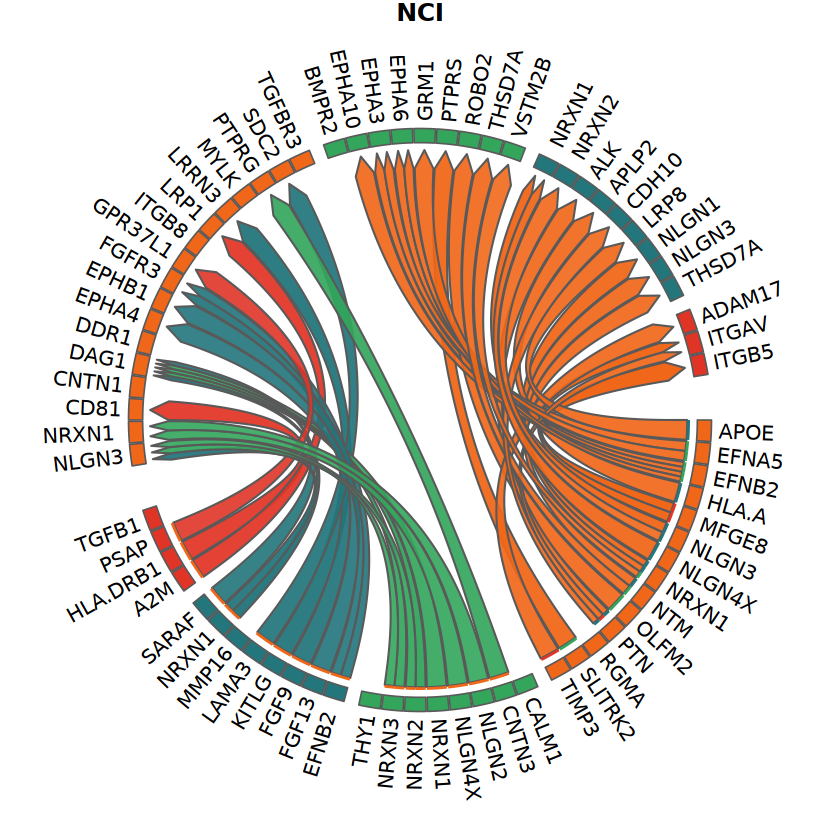

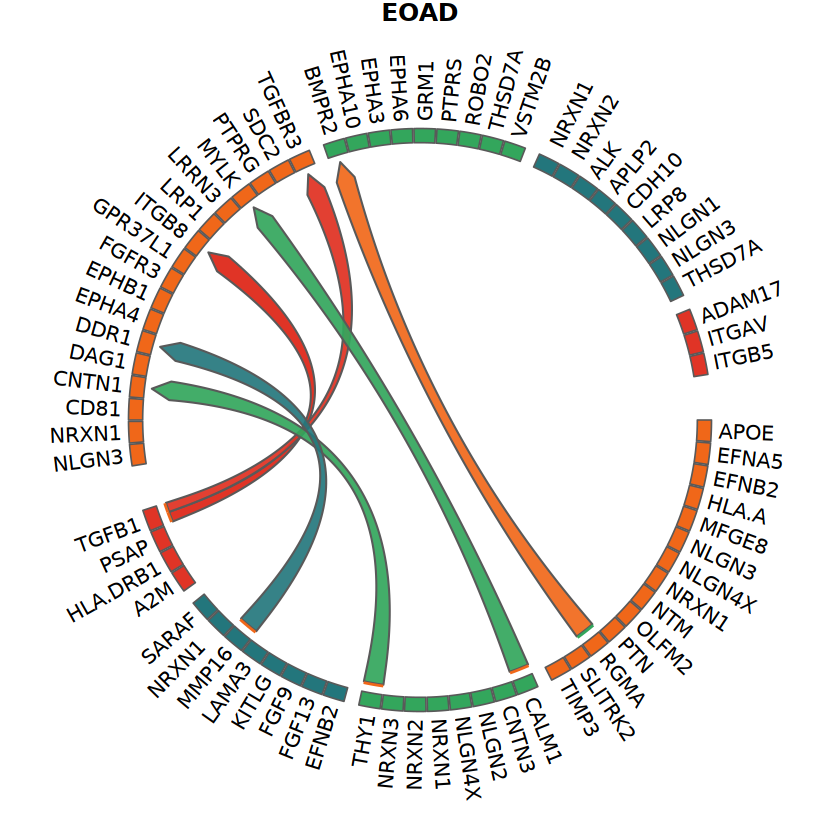

$NCI

$EOAD

$legend


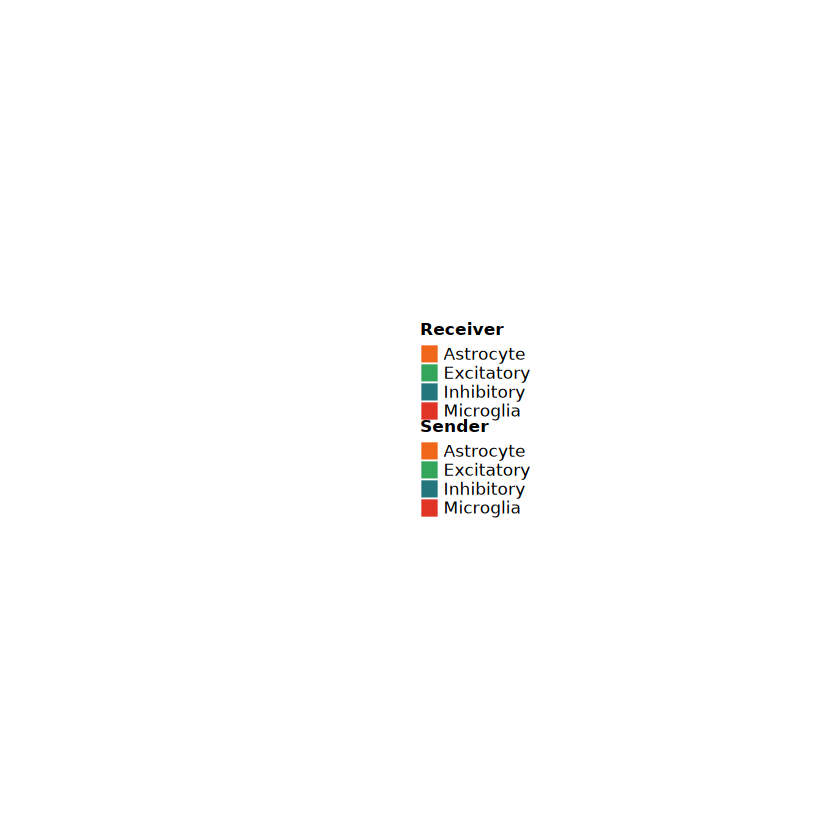

In [17]:
prioritized_tbl_oi = multinichenet_output$prioritization_tables$group_prioritization_tbl %>%
  filter(id %in% prioritized_tbl_oi_all$id) %>%
  distinct(id, sender, receiver, ligand, receptor, group) %>% left_join(prioritized_tbl_oi_all)

prioritized_tbl_oi$prioritization_score[is.na(prioritized_tbl_oi$prioritization_score)] = 0

senders_receivers = union(prioritized_tbl_oi$sender %>% unique(), prioritized_tbl_oi$receiver %>% unique()) %>% sort()

colors_sender = c("#f06719ff","#33a65cff","#23767cff","#e03426ff","#1ba3c6ff","#a26dc2ff")%>% magrittr::set_names(senders_receivers)
colors_receiver = c("#f06719ff","#33a65cff","#23767cff","#e03426ff","#1ba3c6ff","#a26dc2ff")%>% magrittr::set_names(senders_receivers)

circos_list = make_circos_group_comparison(prioritized_tbl_oi, colors_sender, colors_receiver)

# pdf("./Figures/CCC/HIP_circo_ast_0.25.pdf",width = 7,height = 7)
circos_list
# dev.off()

Joining with `by = join_by(id, sender, receiver, sender_receiver,
lr_interaction, group)`
Joining with `by = join_by(id, sender, receiver, sender_receiver,
lr_interaction, group)`


Joining with `by = join_by(receiver, sender_receiver, lr_interaction, group,
LR)`


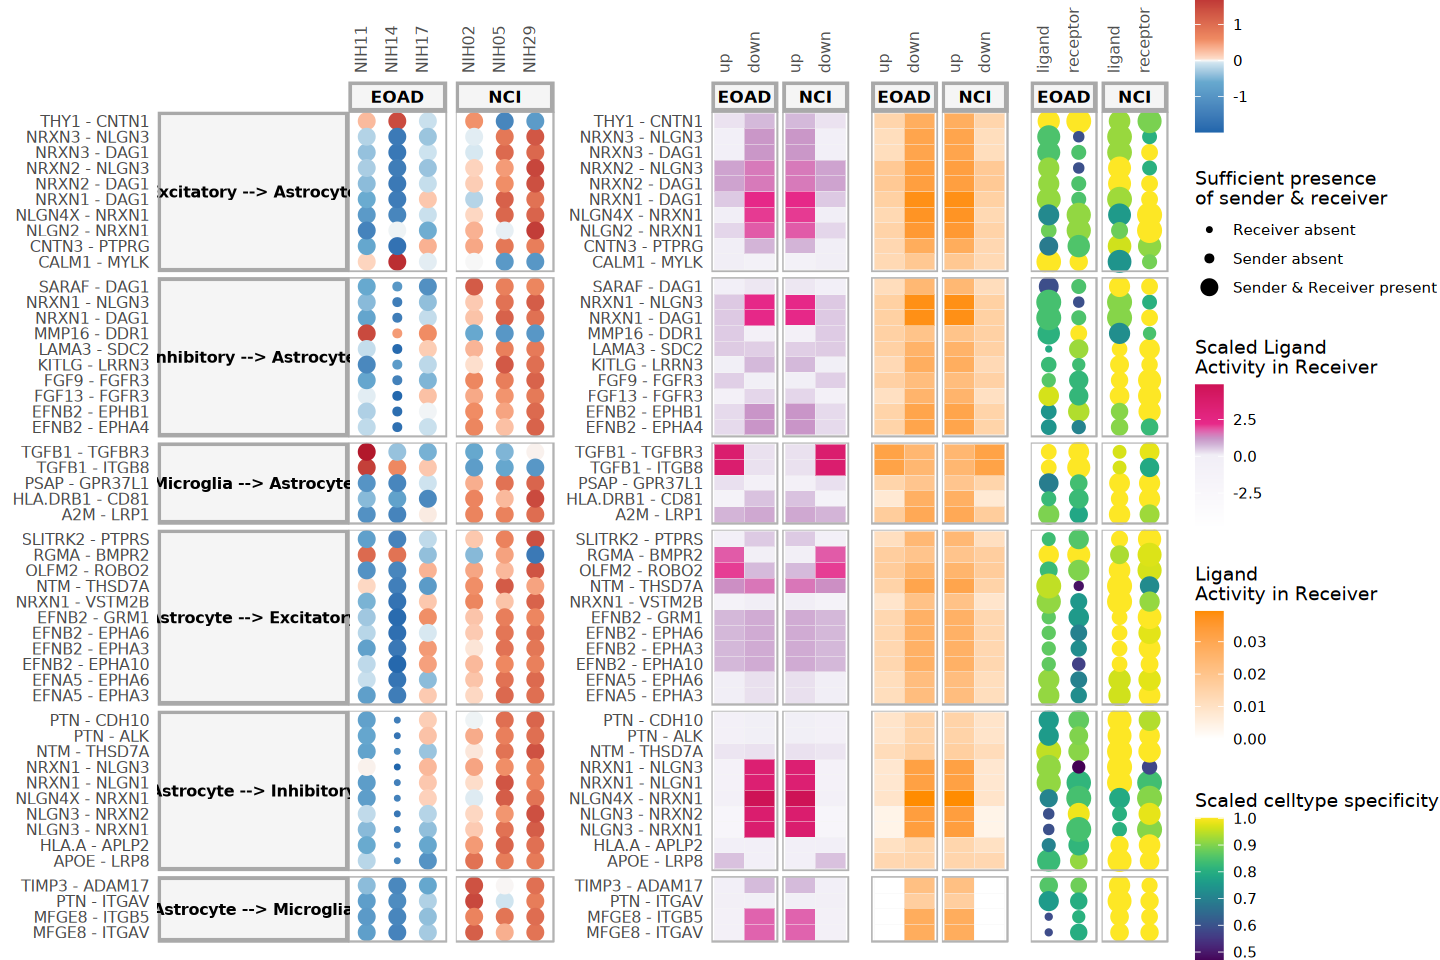

In [19]:
### plot the target gene prediction probability
options(repr.plot.width = 12, repr.plot.height = 8)
plot_oi = make_sample_lr_prod_activity_plots(multinichenet_output$prioritization_tables, prioritized_tbl_oi)
# pdf("./Figures/CCC/HIP_ast_lr_prod_activity_0.25.pdf",width = 12,height = 8)
plot_oi
# dev.off()

In [36]:
group_oi = "NCI"
receiver_oi = "Excitatory" #Microglia
sender_oi = "Astrocyte"
prioritized_tbl_oi = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 5, groups_oi = group_oi, receivers_oi = receiver_oi,senders_oi = sender_oi)
# set case anc control
contrasts_oi = c("'EOAD-NCI','NCI-EOAD'")
contrast_tbl = tibble(contrast =
                        c("EOAD-NCI", "NCI-EOAD"),
                      group = c("EOAD", "NCI"))

In [40]:
combined_plot = make_ligand_activity_target_plot(
    group_oi, 
    receiver_oi, 
    prioritized_tbl_oi, 
    multinichenet_output$prioritization_tables, 
    multinichenet_output$ligand_activities_targets_DEgenes,
    contrast_tbl, 
    multinichenet_output$grouping_tbl, 
    multinichenet_output$celltype_info, 
    ligand_target_matrix, 
    plot_legend = TRUE)

Joining with `by = join_by(contrast)`


Joining with `by = join_by(target)`
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Joining with `by = join_by(contrast)`
Joining with `by = join_by(contrast)`
Joining with `by = join_by(contrast)`
Joining with `by = join_by(gene)`


$combined_plot

$legends

$ligand_target_df
# A tibble: 224 × 4
   ligand  target    score direction_regulation
   <fct>   <fct>     <dbl> <fct>               
 1 EFNA5   ABCB1   0.00661 up                  
 2 OLFM2   ABCB1   0.00643 up                  
 3 EFNB2   ABCB1   0.00574 up                  
 4 SLITRK2 ABCB1   0.00665 up                  
 5 EFNA5   ANKRD28 0.00576 up                  
 6 OLFM2   ANKRD28 0       up                  
 7 EFNB2   ANKRD28 0       up                  
 8 SLITRK2 ANKRD28 0       up                  
 9 EFNA5   BCL2    0.0146  up                  
10 OLFM2   BCL2    0.0129  up                  
# ℹ 214 more rows


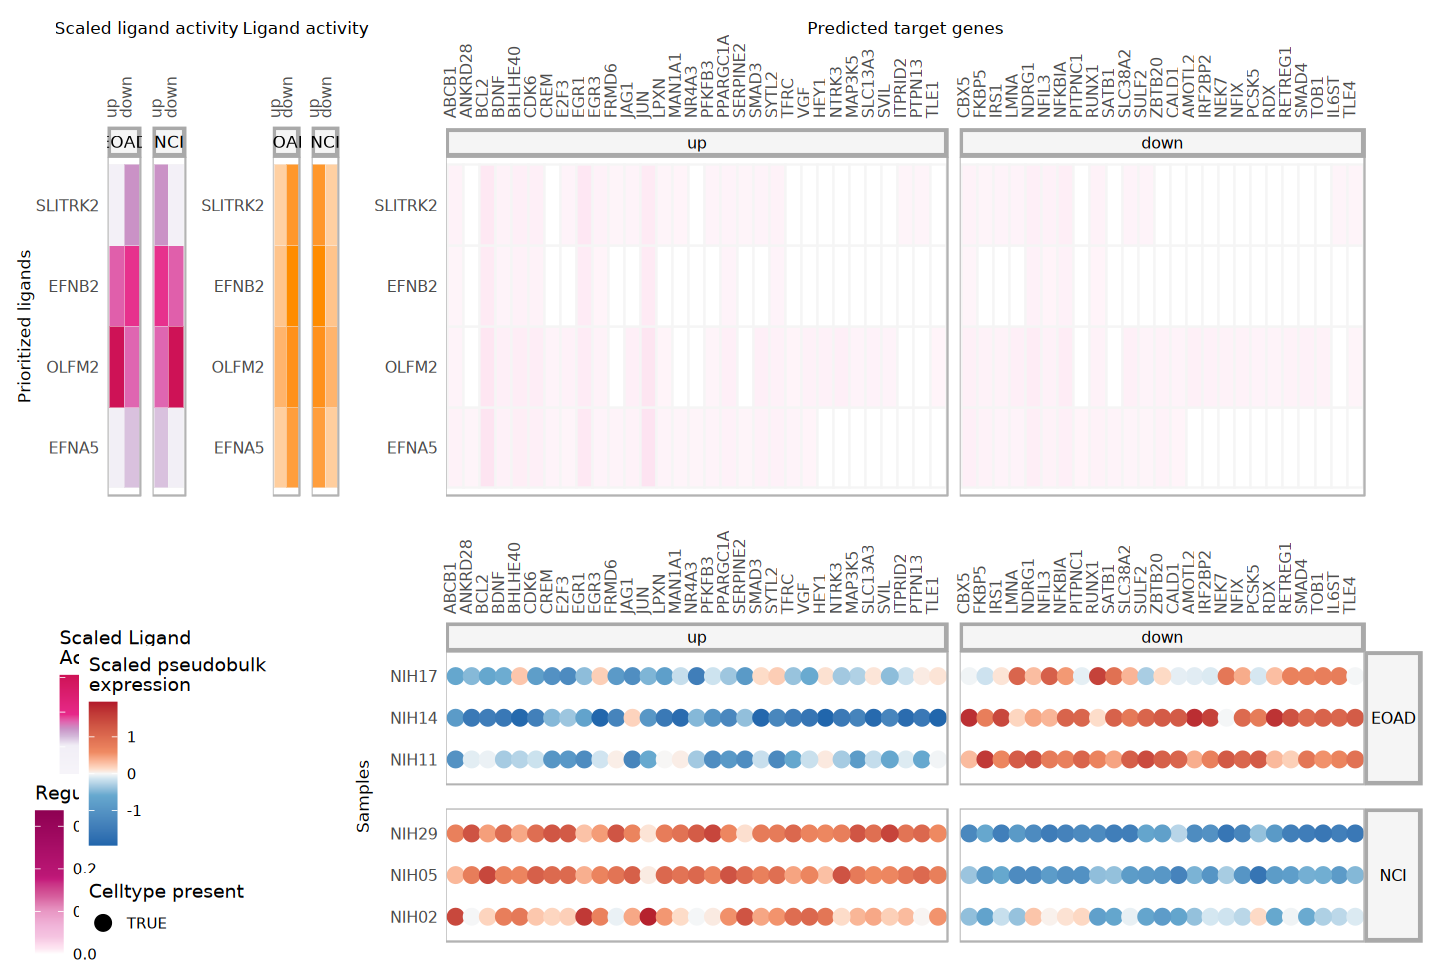

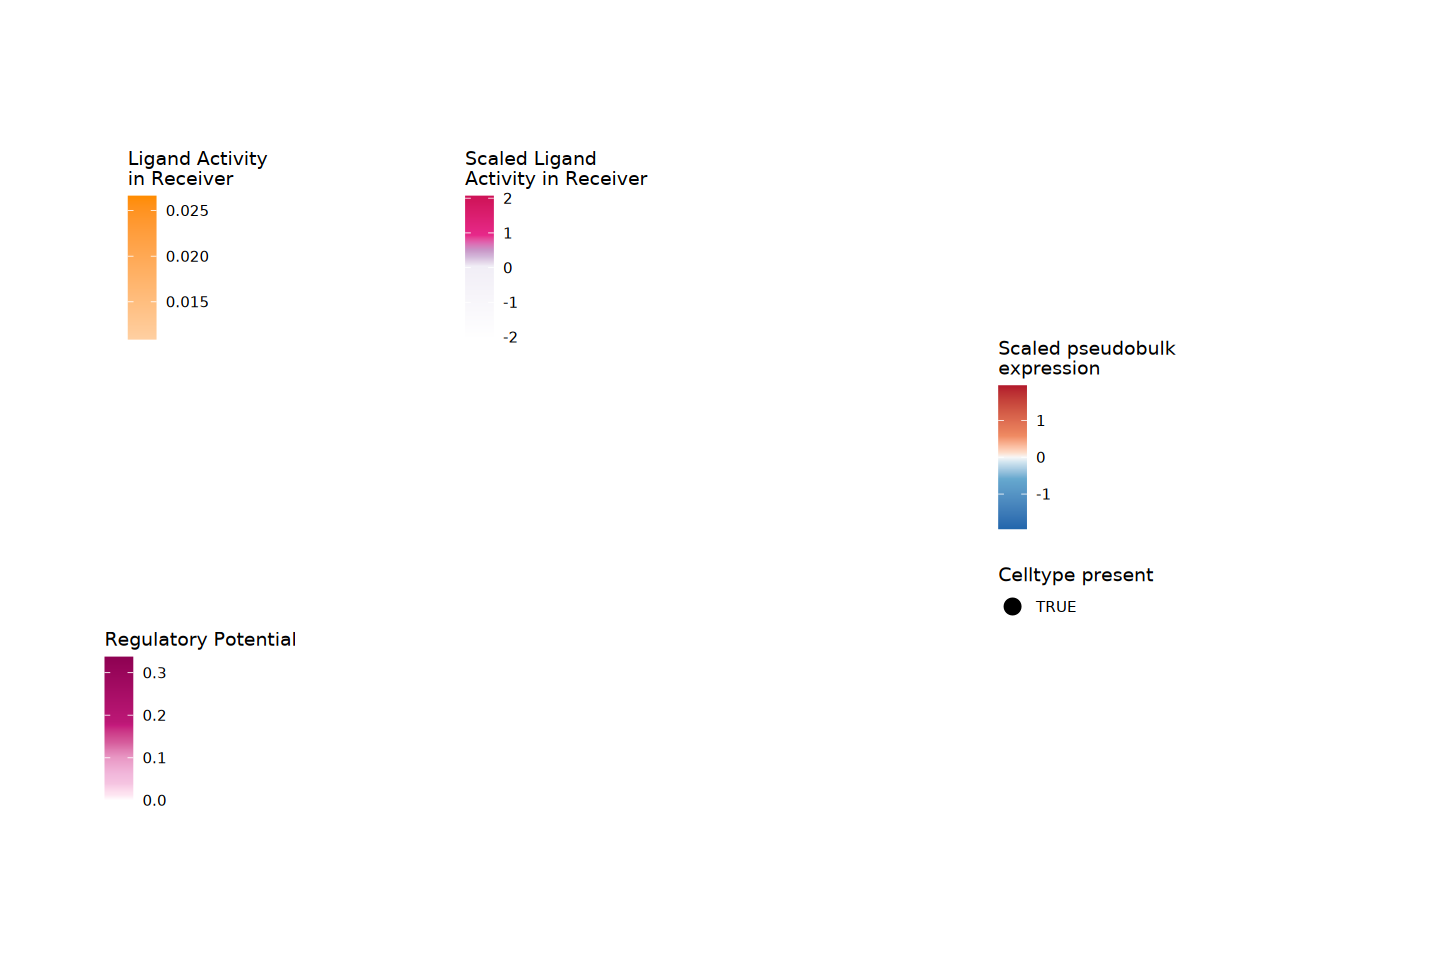

In [42]:

# pdf("./Figures/CCC/EC_mic_ast_deg.pdf",width  = 11,height = 5)
combined_plot
# dev.off()
df = combined_plot$ligand_target_df

In [43]:
write.csv(df, "./Results/CCC/EC_ast_exc_deg.csv", row.names = FALSE)

In [26]:
deg <- read.csv("./Results/DEG/Overlap_mast_mixed_PFC.csv",row.names = 1)
deg <- deg[deg$celltype == "Astrocyte",]
#deg <- deg[deg$celltype %in% c("Microglia"),]

In [27]:
df <- multinichenet_output$ligand_activities_targets_DEgenes

df$ligand_activities <- df$ligand_activities[df$ligand_activities$target %in% deg$gene,]
df$de_genes_df$dir <- ifelse(df$de_genes_df$logFC >0, "pos","neg")
df$de_genes_df$comb <- paste(df$de_genes_df$gene, df$de_genes_df$dir, df$de_genes_df$receiver,sep = "_")

df$de_genes_df <- df$de_genes_df[df$de_genes_df$comb %in% deg$comb,]

Joining with `by = join_by(id, sender, receiver, sender_receiver,
lr_interaction, group)`
Joining with `by = join_by(id, sender, receiver, sender_receiver,
lr_interaction, group)`
Joining with `by = join_by(receiver, sender_receiver, lr_interaction, group,
LR)`


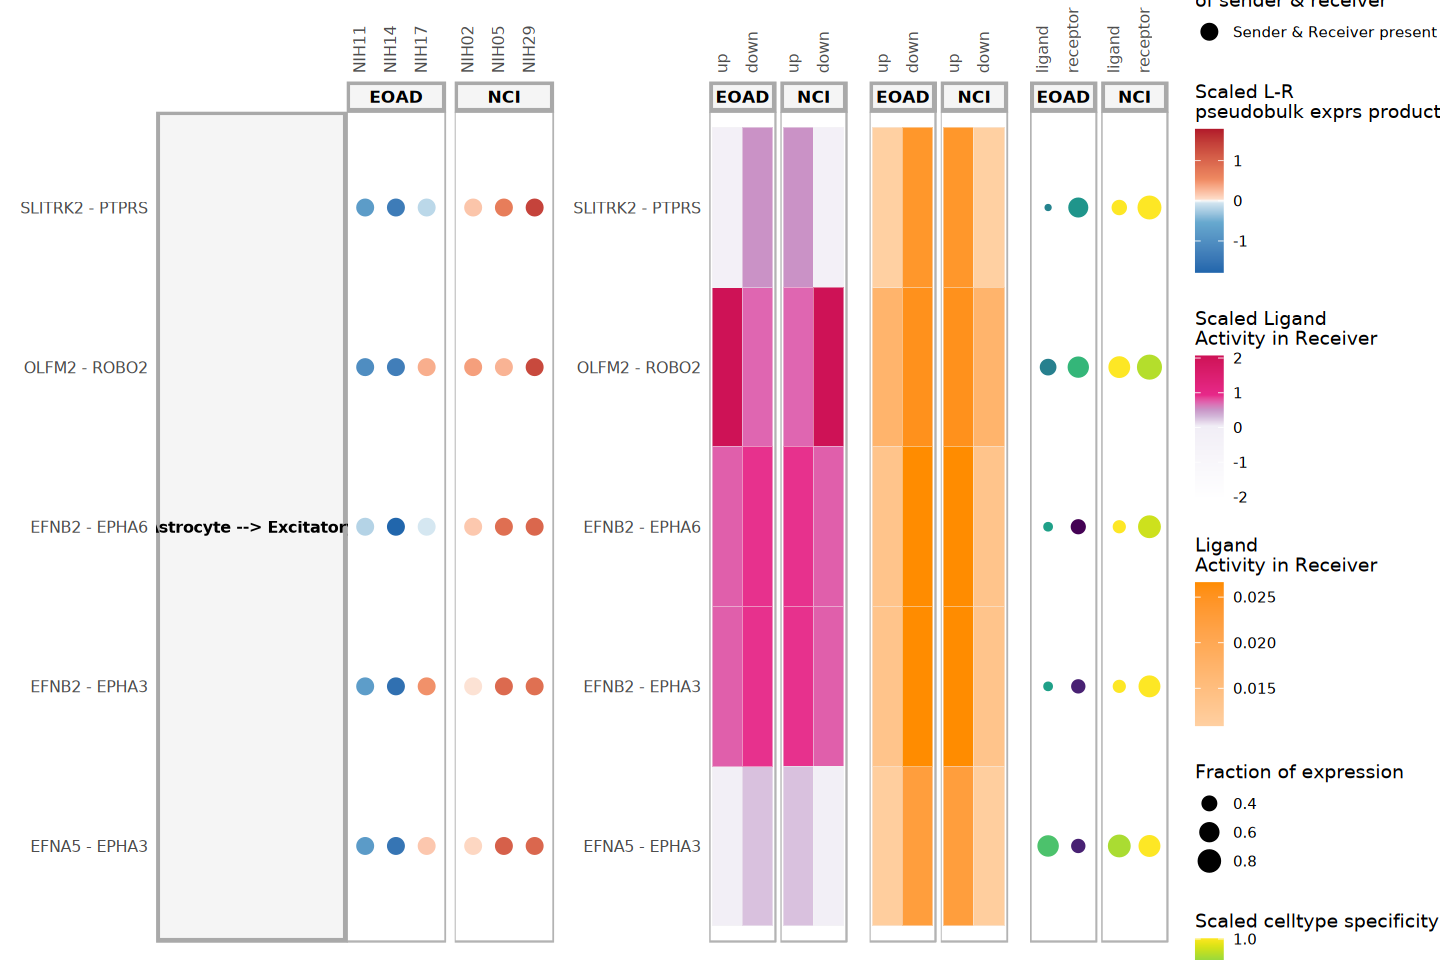

In [28]:
### plot the target gene prediction probability
plot_oi = make_sample_lr_prod_activity_plots(multinichenet_output$prioritization_tables, prioritized_tbl_oi)
#pdf("./Figures/CCC/EC_ast_ex_lr_prod_activity_0.25.pdf",width = 12,height = 8)
plot_oi
#dev.off()

In [ ]:



## check abundance of cells 
abundance_expression_info <-  get_abundance_expression_info(
    sce = sce,
    sample_id = sample_id, 
    group_id = group_id, 
    celltype_id = celltype_id, 
    min_cells = min_cells, 
    senders_oi = senders_oi, 
    receivers_oi = receivers_oi, 
    lr_network = lr_network, 
    batches = batches)



        
## performing DE basded on parameters
DE_info <- get_DE_info(sce = sce, 
                        sample_id = sample_id, 
                        group_id = group_id, 
                        celltype_id = celltype_id, 
                        batches = batches, 
                        covariates = covariates, 
                        contrasts_oi = contrasts_oi, 
                        min_cells = min_cells)

## check how many DEGs calculated by used method
#DE_info$celltype_de$de_output_tidy %>% arrange(-p_val) %>% head()
de_check <- DE_info$celltype_de$de_output_tidy
table(de_check[de_check$p_val <= 0.05,]$cluster_id)

[1] "DE analysis is done:"
[1] "included cell types are:"
[1] "Inhibitory"      "Excitatory"      "Oligodendrocyte" "Astrocyte"      
[5] "OPC"             "Microglia"      



      Astrocyte      Excitatory      Inhibitory       Microglia Oligodendrocyte 
           1026            2136            3872             434            1792 
            OPC 
           1660 

In [ ]:
deg <- read.csv("./Results/DEG/Overlap_mast_mixed_HIP.csv",row.names = 1)
head(deg)

,comb,pct.1,pct.2,avg_log2FC.x,p_val.x,p_val_adj.x,test_statistic,p_val.y,p_val_adj.y,DE_method,DE_type,gene,dir,celltype
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,A2M_pos_Microglia,0.563,0.417,0.6009467,1.422632e-13,2.123563e-09,16.23384,5.598505e-05,3.897205e-04,negbinom,LRT,A2M,pos,Microglia
2,AAMP_neg_Excitatory,0.282,0.091,-0.5467102,2.389972e-11,3.567511e-07,15.81549,6.982842e-05,3.325285e-04,negbinom,LRT,AAMP,neg,Excitatory
3,AASS_neg_Astrocyte,0.408,0.601,-0.7943959,3.010710e-19,4.494086e-15,20.95066,4.712647e-06,2.092947e-05,negbinom,LRT,AASS,neg,Astrocyte
4,AATK_neg_Oligodendrocyte,0.557,0.598,-0.7995944,4.894942e-108,7.306680e-104,17.19387,3.375234e-05,7.500111e-05,negbinom,LRT,AATK,neg,Oligodendrocyte
5,ABAT_neg_Excitatory,0.719,0.478,-0.6929471,3.565650e-22,5.322445e-18,12.40909,4.272501e-04,1.413156e-03,negbinom,LRT,ABAT,neg,Excitatory
6,ABAT_pos_OPC,0.537,0.457,0.4360649,5.501436e-11,8.211994e-07,12.24200,4.672563e-04,2.912351e-03,negbinom,LRT,ABAT,pos,OPC


In [ ]:
df <- DE_info$celltype_de$de_output_tidy
df$dir <- ifelse(df$logFC >0, "pos","neg")
df$comb <- paste(df$gene, df$dir, df$cluster_id, sep = "_")
DE_info$celltype_de$de_output_tidy <- DE_info$celltype_de$de_output_tidy[df$comb %in% deg$comb,]
#DE_info$celltype_de$de_output_tidy

In [ ]:
### quality control figures
pdf("./Figures/CCC/CCC_QC_HIP.pdf",width = 12,height = 10)
abundance_expression_info$abund_plot_sample
abundance_expression_info$abund_plot_group
DE_info$hist_pvals
dev.off()

png 
  2

In [ ]:
## organize the information for next steps
# not using empirical p values
empirical_pval = FALSE
if(empirical_pval == FALSE){
  celltype_de = DE_info$celltype_de$de_output_tidy
} else {
  celltype_de = DE_info_emp$de_output_tidy_emp %>% dplyr::select(-p_val, -p_adj) %>% dplyr::rename(p_val = p_emp, p_adj = p_adj_emp)
}

## organize the format
sender_receiver_de = combine_sender_receiver_de(
  sender_de = celltype_de,
  receiver_de = celltype_de,
  senders_oi = senders_oi,
  receivers_oi = receivers_oi,
  lr_network = lr_network
)

In [ ]:
## check some ligand of interest
#sender_receiver_de[sender_receiver_de$receptor %in% c("TREM2") & sender_receiver_de$p_val_receptor < 0.05,]
#sender_receiver_de[sender_receiver_de$ligand %in% c("APOE") & sender_receiver_de$p_val_ligand < 0.05,]

LR_oi <- sender_receiver_de[sender_receiver_de$p_val_receptor < 0.05 & sender_receiver_de$p_val_ligand < 0.05,]
LR_oi[LR_oi$receptor %in% c("TREM2"),]
LR_oi[LR_oi$ligand %in% c("APOE"),]

contrast,sender,receiver,ligand,receptor,lfc_ligand,lfc_receptor,ligand_receptor_lfc_avg,p_val_ligand,p_adj_ligand,p_val_receptor,p_adj_receptor
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


contrast,sender,receiver,ligand,receptor,lfc_ligand,lfc_receptor,ligand_receptor_lfc_avg,p_val_ligand,p_adj_ligand,p_val_receptor,p_adj_receptor
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [ ]:
## using default parameters
# using nominal p values because of small sample size
logFC_threshold = 0.75
p_val_threshold = 0.05
fraction_cutoff = 0.25

# if using adjusted p value
p_val_adj = FALSE

top_n_target = 250

verbose = TRUE
cores_system = 12
n.cores = min(cores_system, sender_receiver_de$receiver %>% unique() %>% length())

In [ ]:
ligand_activities_targets_DEgenes = suppressMessages(suppressWarnings(get_ligand_activities_targets_DEgenes(
  receiver_de = celltype_de,
  receivers_oi = receivers_oi,
  ligand_target_matrix = ligand_target_matrix,
  logFC_threshold = logFC_threshold,
  p_val_threshold = p_val_threshold,
  p_val_adj = p_val_adj,
  top_n_target = top_n_target,
  verbose = verbose, 
  n.cores = n.cores
)))

In [ ]:
## using default parameters
prioritizing_weights_DE = c("de_ligand" = 1,
                         "de_receptor" = 1)
prioritizing_weights_activity = c("activity_scaled" = 2)

prioritizing_weights_expression_specificity = c("exprs_ligand" = 2,
                         "exprs_receptor" = 2)

prioritizing_weights_expression_sufficiency = c("frac_exprs_ligand_receptor" = 1)

prioritizing_weights_relative_abundance = c( "abund_sender" = 0,
                         "abund_receiver" = 0)

In [ ]:
prioritizing_weights = c(prioritizing_weights_DE, 
                         prioritizing_weights_activity, 
                         prioritizing_weights_expression_specificity,
                         prioritizing_weights_expression_sufficiency, 
                         prioritizing_weights_relative_abundance)

sender_receiver_tbl = sender_receiver_de %>% dplyr::distinct(sender, receiver)

metadata_combined = SummarizedExperiment::colData(sce) %>% tibble::as_tibble()

if(!is.na(batches)){
  grouping_tbl = metadata_combined[,c(sample_id, group_id, batches)] %>% tibble::as_tibble() %>% dplyr::distinct()
  colnames(grouping_tbl) = c("sample","group",batches)
} else {
  grouping_tbl = metadata_combined[,c(sample_id, group_id)] %>% tibble::as_tibble() %>% dplyr::distinct()
  colnames(grouping_tbl) = c("sample","group")
}

prioritization_tables = suppressMessages(generate_prioritization_tables(
  sender_receiver_info = abundance_expression_info$sender_receiver_info,
  sender_receiver_de = sender_receiver_de,
  ligand_activities_targets_DEgenes = ligand_activities_targets_DEgenes,
  contrast_tbl = contrast_tbl,
  sender_receiver_tbl = sender_receiver_tbl,
  grouping_tbl = grouping_tbl,
  prioritizing_weights = prioritizing_weights,
  fraction_cutoff = fraction_cutoff, 
  abundance_data_receiver = abundance_expression_info$abundance_data_receiver,
  abundance_data_sender = abundance_expression_info$abundance_data_sender
))

In [ ]:
# briefly check the results
#dim(prioritization_tables$group_prioritization_tbl)
#dim(prioritization_tables$sample_prioritization_tbl)
#dim(prioritization_tables$ligand_activities_target_de_tbl)
#prioritization_tables$group_prioritization_tbl %>% head(5)
#prioritization_tables$sample_prioritization_tbl %>% head(5)

In [ ]:
## Add information on prior knowledge and expression correlation between LR and target expression
lr_target_prior_cor <- lr_target_prior_cor_inference(
    prioritization_tables$group_prioritization_tbl$receiver %>% unique(),
    abundance_expression_info, 
    celltype_de, 
    grouping_tbl, 
    prioritization_tables, 
    ligand_target_matrix, 
    logFC_threshold = logFC_threshold, 
    p_val_threshold = p_val_threshold, 
    p_val_adj = p_val_adj)

In [ ]:
## combining into a organized list and save
path = "./Results/CCC/"

multinichenet_output = list(
    celltype_info = abundance_expression_info$celltype_info,
    celltype_de = celltype_de,
    sender_receiver_info = abundance_expression_info$sender_receiver_info,
    sender_receiver_de =  sender_receiver_de,
    ligand_activities_targets_DEgenes = ligand_activities_targets_DEgenes,
    prioritization_tables = prioritization_tables,
    grouping_tbl = grouping_tbl,
    lr_target_prior_cor = lr_target_prior_cor
  ) 
multinichenet_output = make_lite_output(multinichenet_output)

save = TRUE
if(save == TRUE){
  saveRDS(multinichenet_output, paste0(path, "HIP_multinichenet_output_0.25.rds"))

}

## Working on downstream analysis of each brain region

In [45]:
### loading results
#multinichenet_output <- readRDS("./Results/CCC/PFC_multinichenet_output_0.25.rds")
multinichenet_output <- readRDS("./Results/CCC/EC_multinichenet_output_0.25.rds")
#multinichenet_output <- readRDS("./Results/CCC/HIP_multinichenet_output_0.25.rds")

In [ ]:
df <- multinichenet_output$prioritization_tables$group_prioritization_tbl
df_oi <- df[df$prioritization_score>0.8,]
table(df_oi$group)
#unlist(df_oi[1,])


EOAD  NCI 
 294  914 

In [ ]:
#df_oi[grep("NCAM",df_oi$ligand),]

In [47]:
## check the top 50 prediction across all contrasts, senders, and receivers of interest.
#prioritized_tbl_oi_all = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 50, rank_per_group = F)

## astrocyte
#prioritized_tbl_oi_all_1 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#senders_oi = "Astrocyte",receivers_oi = c("Excitatory","Inhibitory","Microglia")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all_2 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#receivers_oi = "Astrocyte",senders_oi = c("Excitatory","Inhibitory","Microglia")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)

## Oligodendrocyte
#prioritized_tbl_oi_all_1 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#senders_oi = "Oligodendrocyte",receivers_oi = c("Excitatory","Inhibitory","Microglia","Astrocyte")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all_2 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
#receivers_oi = "Oligodendrocyte",senders_oi = c("Excitatory","Inhibitory","Microglia","Astrocyte")) #,"Oligodendrocyte","OPC"
#prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)

#table(multinichenet_output$lr_target_prior_cor$spearman > 0.33)
## Microglia
prioritized_tbl_oi_all_1 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
senders_oi = "Microglia",receivers_oi = c("Excitatory","Inhibitory","Astrocyte")) #,"Oligodendrocyte","OPC"
prioritized_tbl_oi_all_2 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 25, rank_per_group = F,
receivers_oi = "Microglia",senders_oi = c("Excitatory","Inhibitory","Astrocyte")) #,"Oligodendrocyte","OPC"
prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)

#prioritized_tbl_oi_all = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 50, rank_per_group = F,
#senders_oi = c("Astrocyte","Microglia"),receivers_oi = c("Excitatory","Inhibitory","Astrocyte","Microglia"))



#prioritized_tbl_oi_all <- rbind(prioritized_tbl_oi_all_1,prioritized_tbl_oi_all_2)
#prioritized_tbl_oi_all[1:20,]
##prioritized_tbl_oi_all

Joining with `by = join_by(id, sender, receiver, ligand, receptor, group)`


Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`
Joining with `by = join_by(sender)`
Joining with `by = join_by(receiver)`


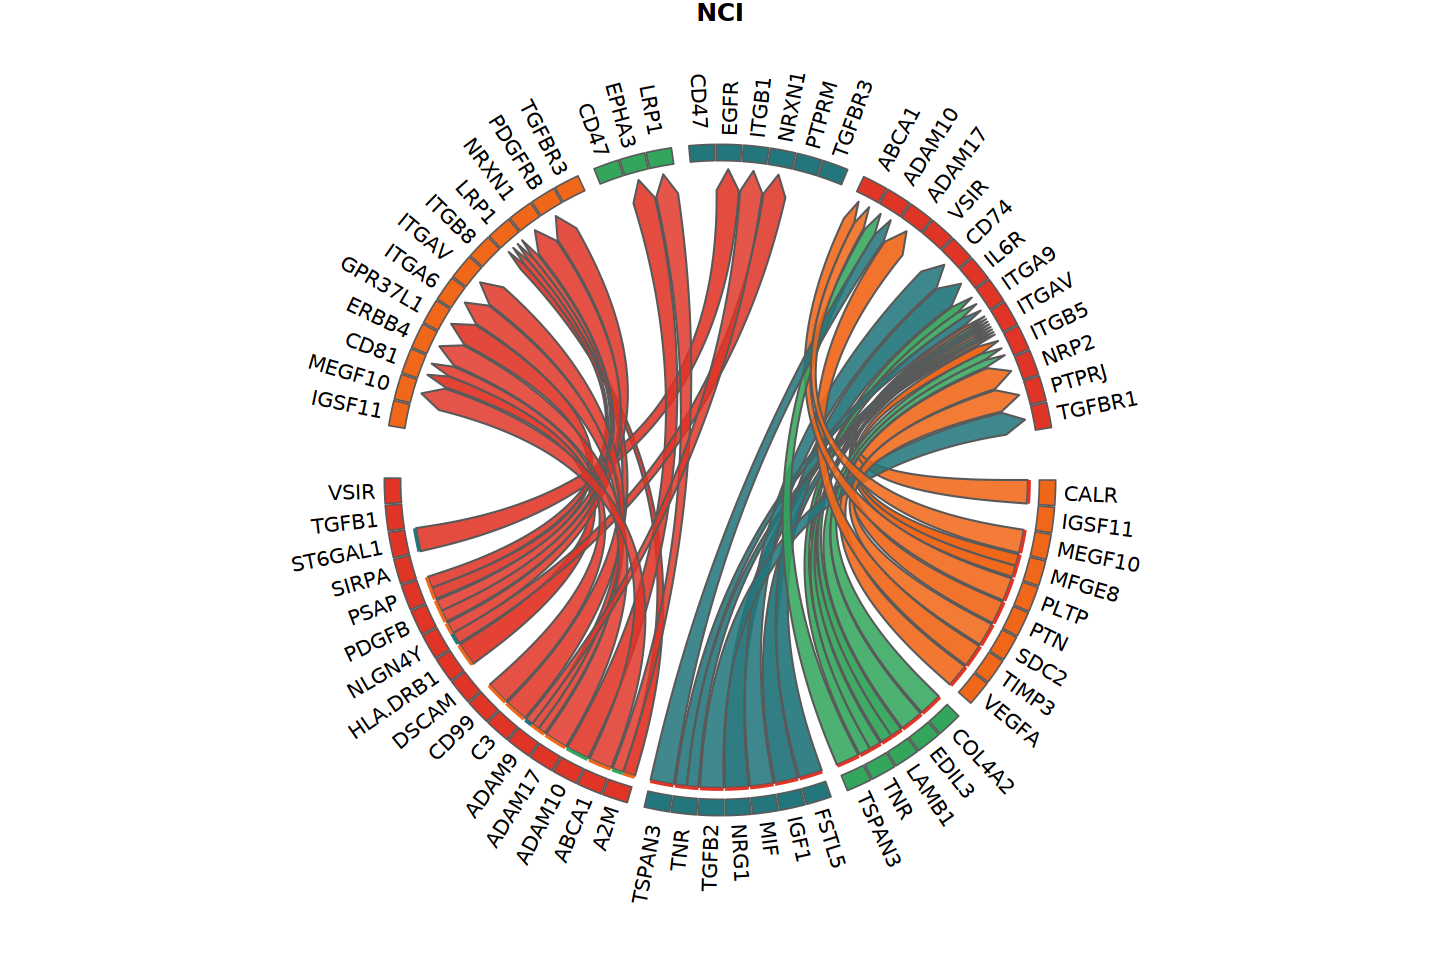

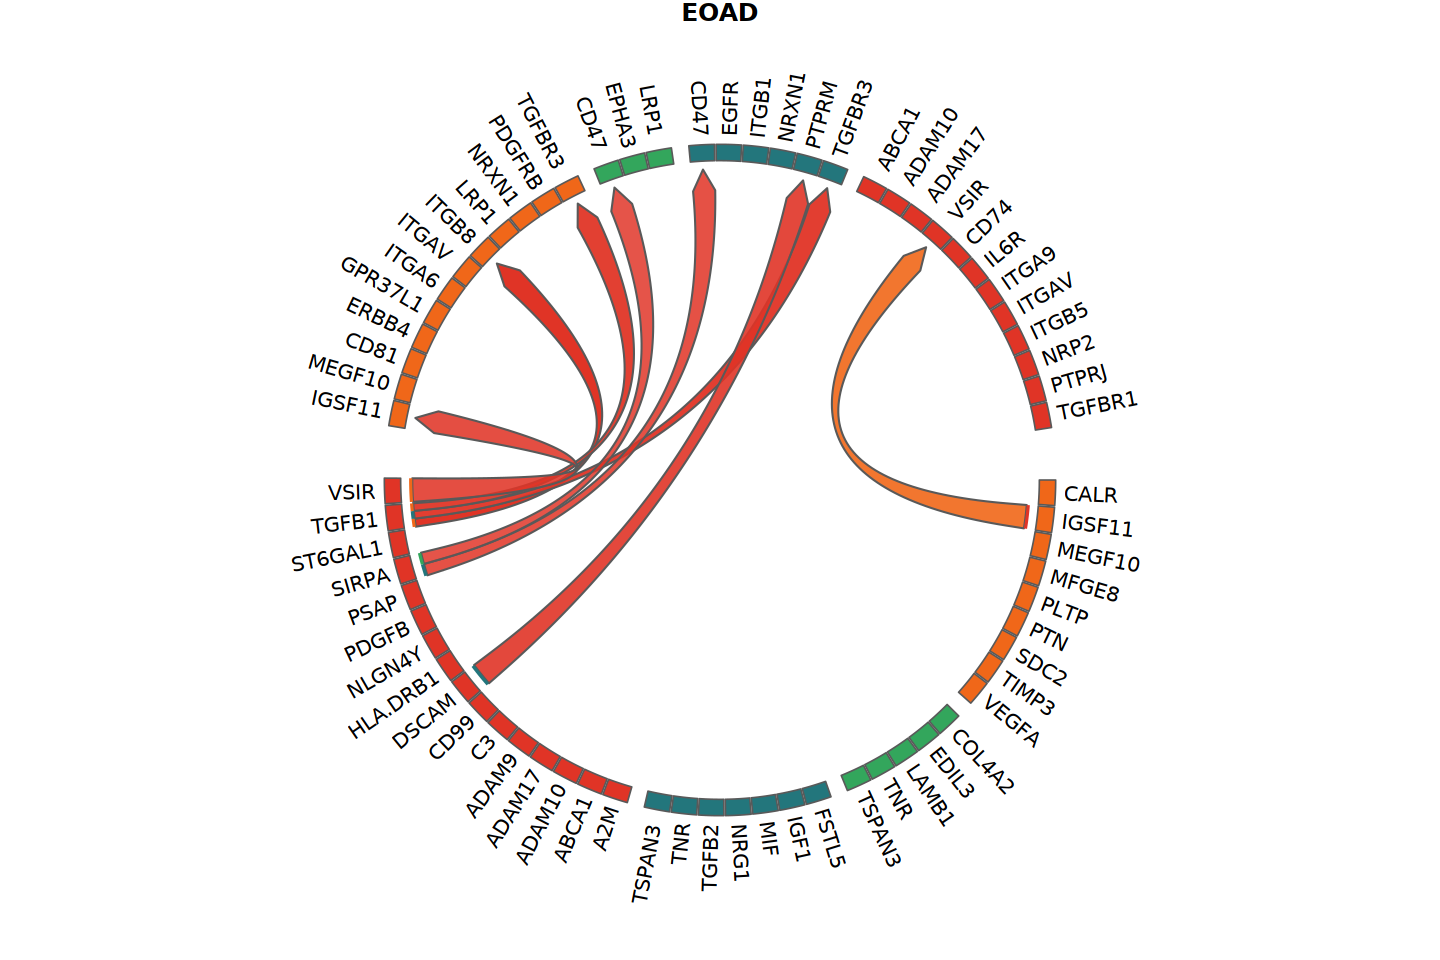

$NCI

$EOAD

$legend


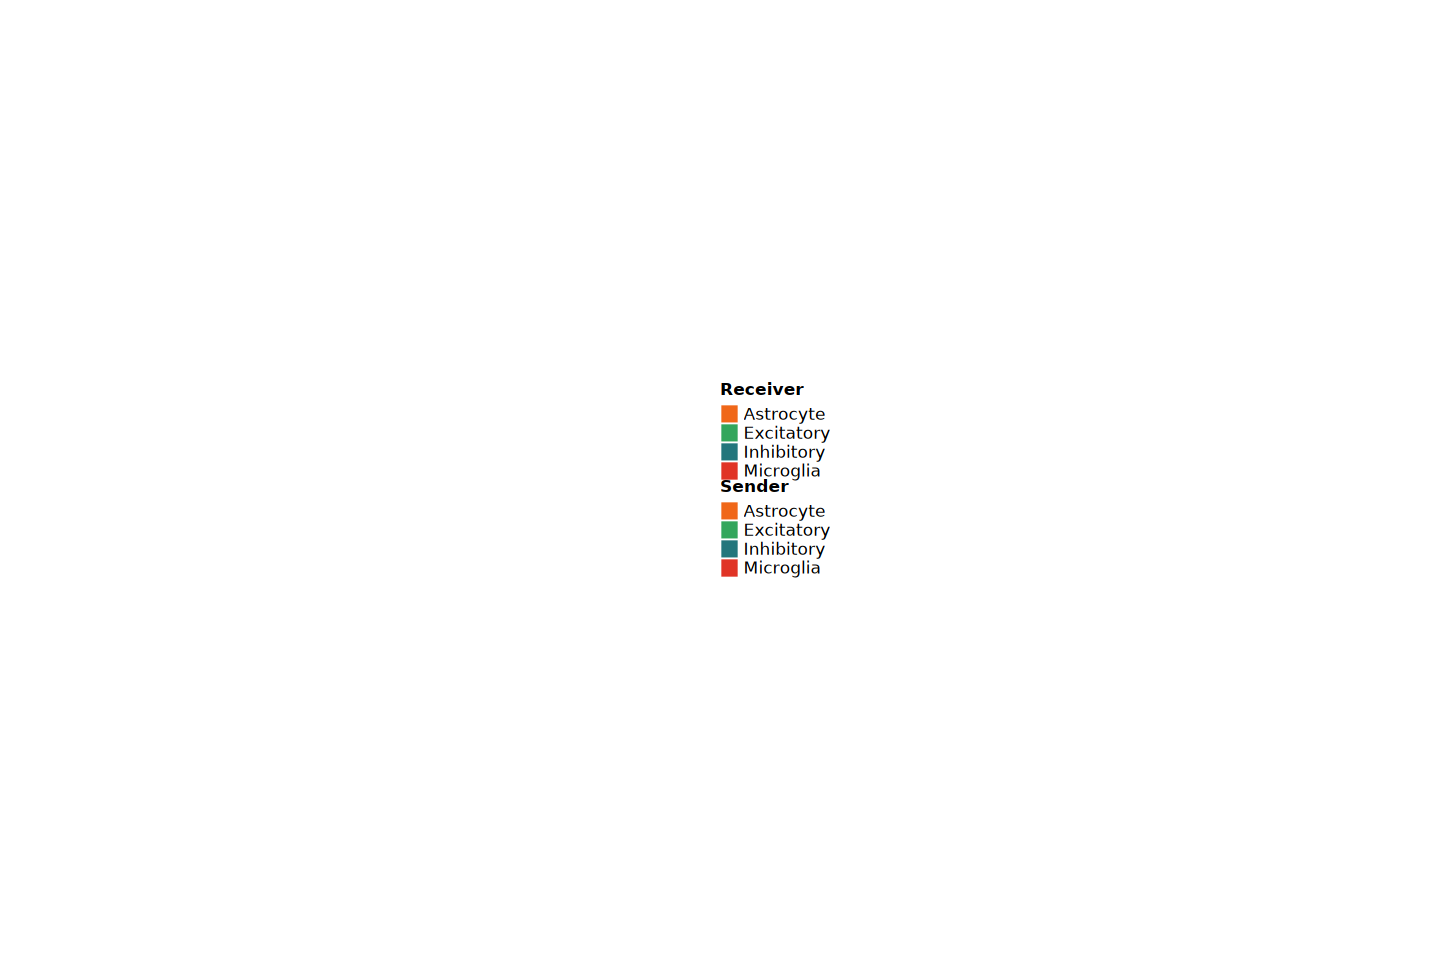

In [48]:
prioritized_tbl_oi = multinichenet_output$prioritization_tables$group_prioritization_tbl %>%
  filter(id %in% prioritized_tbl_oi_all$id) %>%
  distinct(id, sender, receiver, ligand, receptor, group) %>% left_join(prioritized_tbl_oi_all)

prioritized_tbl_oi$prioritization_score[is.na(prioritized_tbl_oi$prioritization_score)] = 0

senders_receivers = union(prioritized_tbl_oi$sender %>% unique(), prioritized_tbl_oi$receiver %>% unique()) %>% sort()

colors_sender = c("#f06719ff","#33a65cff","#23767cff","#e03426ff","#1ba3c6ff","#a26dc2ff")%>% magrittr::set_names(senders_receivers)
colors_receiver = c("#f06719ff","#33a65cff","#23767cff","#e03426ff","#1ba3c6ff","#a26dc2ff")%>% magrittr::set_names(senders_receivers)

circos_list = make_circos_group_comparison(prioritized_tbl_oi, colors_sender, colors_receiver)

#pdf("./Figures/CCC/EC_circo_mic_0.25.pdf",width = 7,height = 7)
circos_list
#dev.off()

In [49]:
prioritized_tbl_oi = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 5, rank_per_group = F, senders_oi = "Microglia",receivers_oi = c("Astrocyte"))
prioritized_tbl_oi

group,sender,receiver,ligand,receptor,id,prioritization_score,prioritization_rank
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
EOAD,Microglia,Astrocyte,TGFB1,ITGB8,TGFB1_ITGB8_Microglia_Astrocyte,0.9493790,1
NCI,Microglia,Astrocyte,HLA.DRB1,CD81,HLA.DRB1_CD81_Microglia_Astrocyte,0.8974635,2
EOAD,Microglia,Astrocyte,TGFB1,TGFBR3,TGFB1_TGFBR3_Microglia_Astrocyte,0.8963464,3
NCI,Microglia,Astrocyte,A2M,LRP1,A2M_LRP1_Microglia_Astrocyte,0.8960257,4
NCI,Microglia,Astrocyte,PSAP,GPR37L1,PSAP_GPR37L1_Microglia_Astrocyte,0.8667420,5


In [71]:
group_oi = "NCI"
receiver_oi = "Astrocyte"
sender_oi = "Microglia"
prioritized_tbl_oi_M_10 = get_top_n_lr_pairs(multinichenet_output$prioritization_tables, 4, groups_oi = group_oi, receivers_oi = receiver_oi,senders_oi = sender_oi)
# set case anc control
contrasts_oi = c("'EOAD-NCI','NCI-EOAD'")
contrast_tbl = tibble(contrast =
                        c("EOAD-NCI", "NCI-EOAD"),
                      group = c("EOAD", "NCI"))

In [72]:
combined_plot = make_ligand_activity_target_plot(
    group_oi, 
    receiver_oi, 
    prioritized_tbl_oi_M_10, 
    multinichenet_output$prioritization_tables, 
    multinichenet_output$ligand_activities_targets_DEgenes,
    contrast_tbl, 
    multinichenet_output$grouping_tbl, 
    multinichenet_output$celltype_info, 
    ligand_target_matrix, 
    plot_legend = TRUE)

Joining with `by = join_by(contrast)`


Joining with `by = join_by(target)`
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Joining with `by = join_by(contrast)`
Joining with `by = join_by(contrast)`
Joining with `by = join_by(contrast)`
Joining with `by = join_by(gene)`


$combined_plot

$legends

$ligand_target_df
# A tibble: 183 × 4
   ligand   target   score direction_regulation
   <fct>    <fct>    <dbl> <fct>               
 1 PSAP     ADGRG1 0.00632 up                  
 2 A2M      ADGRG1 0       up                  
 3 HLA.DRB1 ADGRG1 0       up                  
 4 PSAP     AGT    0.00884 up                  
 5 A2M      AGT    0.00697 up                  
 6 HLA.DRB1 AGT    0.00652 up                  
 7 PSAP     ALDOC  0.00671 up                  
 8 A2M      ALDOC  0.00648 up                  
 9 HLA.DRB1 ALDOC  0       up                  
10 PSAP     ENO1   0.00734 up                  
# ℹ 173 more rows


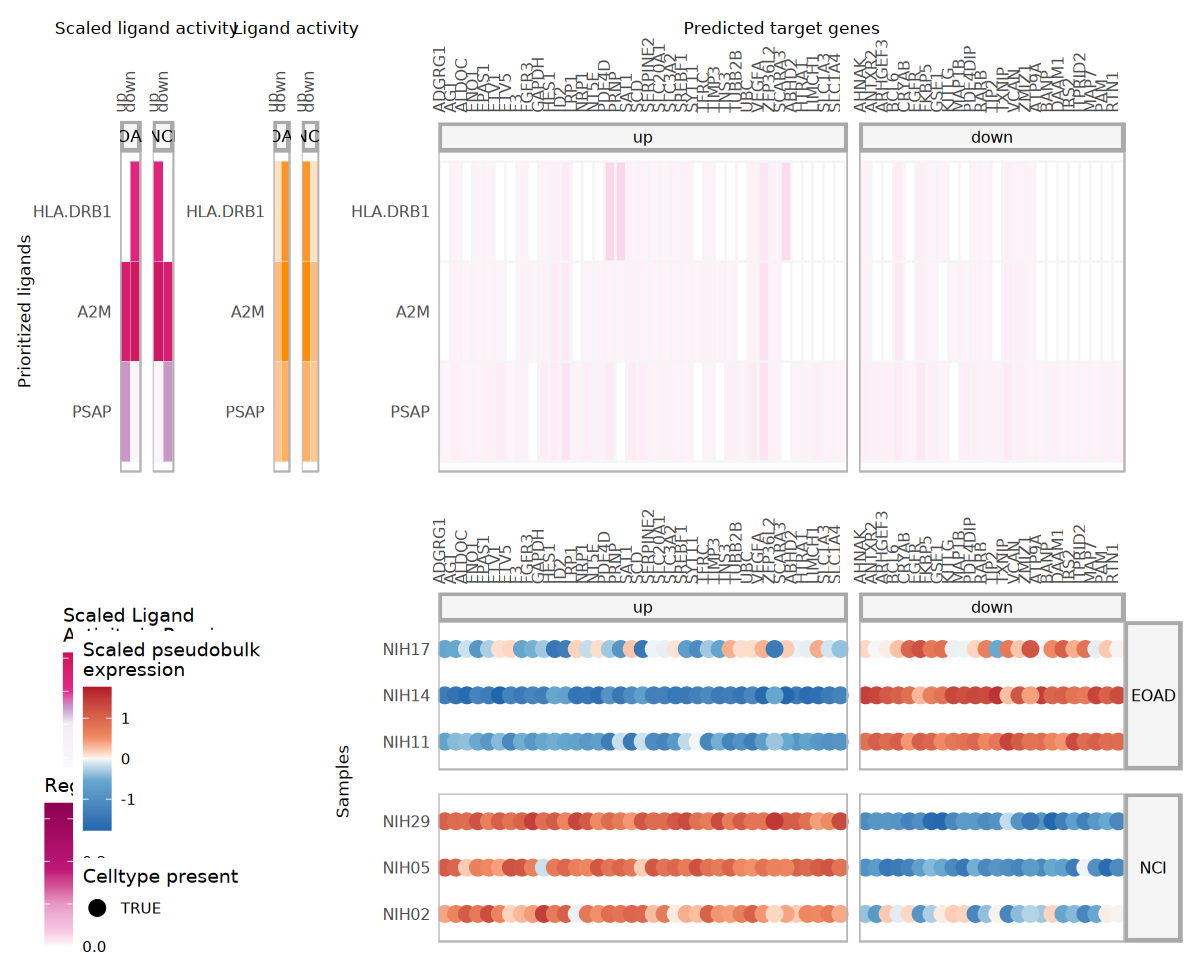

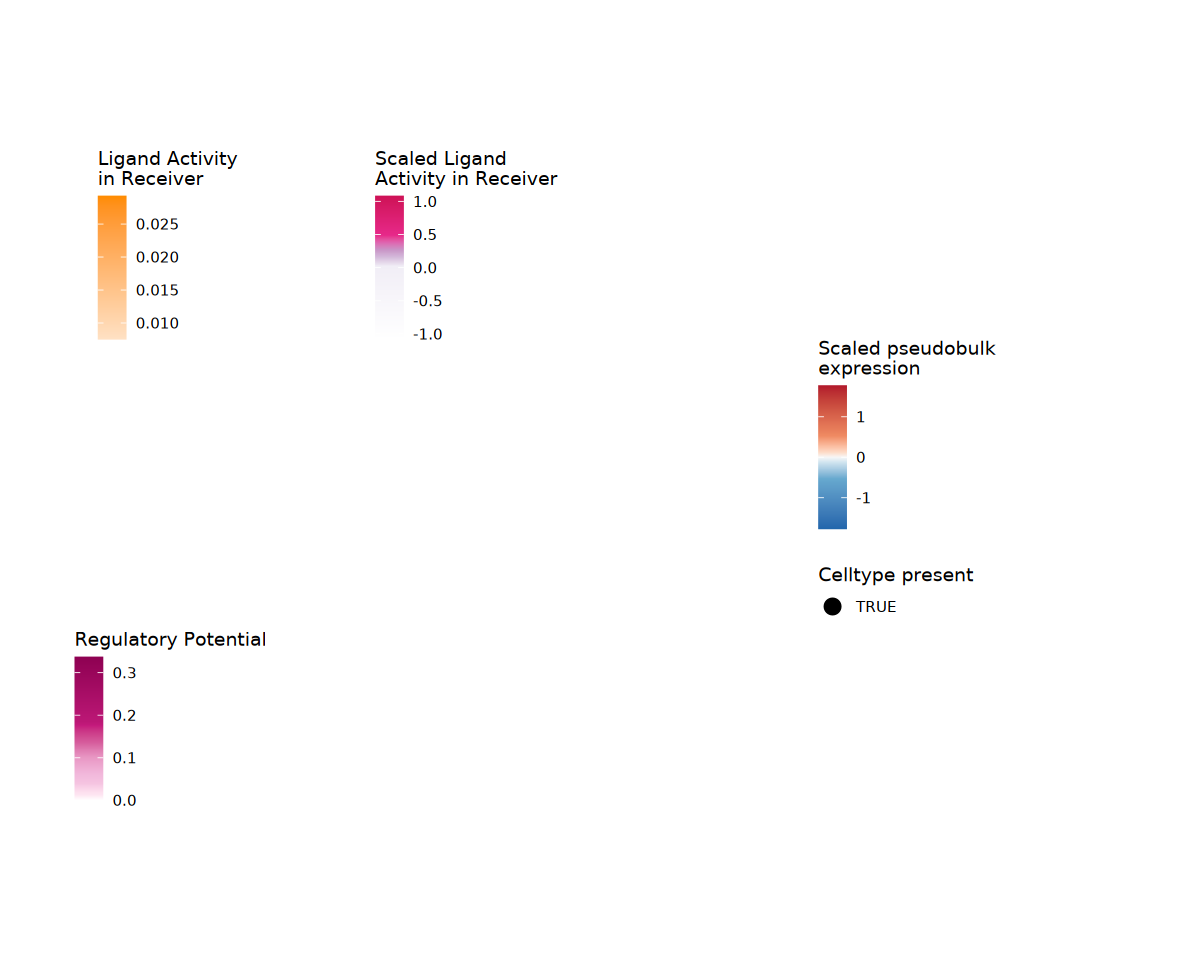

In [73]:
combined_plot
df = combined_plot$ligand_target_df

In [74]:
write.csv(df,"./Results/CCC/EC_mic_ast_deg.csv", row.names = FALSE)

In [ ]:
pdf("./Figures/CCC/try.pdf",width  = 13,height = 5)
combined_plot
dev.off()

$combined_plot

$legends


png 
  2

## performing enrichment analysis on top targeted DEGs

In [ ]:
## load libraries
#enrichment analysis
library(clusterProfiler)
library('org.Hs.eg.db')

In [95]:
## read the ligand target df
df <- read.csv("./Results/CCC/EC_ast_exc_deg.csv")
head(df)

,ligand,target,score,direction_regulation
,<chr>,<chr>,<dbl>,<chr>
1,EFNA5,ABCB1,0.006609731,up
2,OLFM2,ABCB1,0.006432467,up
3,EFNB2,ABCB1,0.005744396,up
4,SLITRK2,ABCB1,0.006647676,up
5,EFNA5,ANKRD28,0.005757063,up
6,OLFM2,ANKRD28,0.000000000,up


In [96]:
#########################################################################
#### find enriched GOBP for consistent signals in inhibitory neurons ####
#########################################################################
df$gene_id <- mapIds(
  # Replace with annotation package for the organism relevant to your data
  org.Hs.eg.db,
  # The vector of gene identifiers we want to map
  keys = df$target,
  # Replace with the type of gene identifiers in your data
  keytype = "SYMBOL",
  # Replace with the type of gene identifiers you would like to map to
  column = "ENTREZID",
  # In the case of 1:many mappings, return the
  # first one. This is default behavior!
  multiVals = "first"
)

### run ORA and plot the non-redundant result of inhibitory ###
# & degs$comb %in% deg_oi,
ego_up <- enrichGO(gene          = unique(df[df$direction_regulation == "down",]$gene_id),
                OrgDb         = org.Hs.eg.db,
                ont           = c("BP"),
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
#                qvalueCutoff  = 0.2,
                readable      = TRUE)

ego_down <- enrichGO(gene          = unique(df[df$direction_regulation == "up",]$gene_id),
                OrgDb         = org.Hs.eg.db,
                ont           = c("BP"),
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
#                qvalueCutoff  = 0.2,
                readable      = TRUE)

# remove redundancy
ego_up <- simplify(ego_up)
ego_down <- simplify(ego_down)

'select()' returned 1:1 mapping between keys and columns



In [97]:
top_terms_up <- ego_up@result %>%
  filter(p.adjust < 0.05) %>%
  arrange(p.adjust) %>%
  slice_head(n = 5)

# Ensure the Description is treated as a factor and ordered
top_terms_up$Description <- factor(top_terms_up$Description, levels = rev(top_terms_up$Description))

# Plot the bar plot
options(repr.plot.width = 10, repr.plot.height = 8)
p1 = ggplot(top_terms_up, aes(x = Description, y = -log10(p.adjust))) +
        geom_bar(stat = "identity", fill = "#f06719") +
        coord_flip() +
        labs(
          x = "GO Biological Process",
          y = expression(-log[10]~adjusted~p~value),
          title = "Top 5 enriched GOBP terms in upregulated DEGs"
        ) +
        theme_minimal() + 
        theme(panel.border = element_rect(color = "black", fill = NA, size = 1),
            plot.title = element_text(size = 16, face = "bold"),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12)
            )

top_terms_down <- ego_down@result %>%
  filter(p.adjust < 0.05) %>%
  arrange(p.adjust) %>%
  slice_head(n = 5)

# Ensure the Description is treated as a factor and ordered
top_terms_down$Description <- factor(top_terms_down$Description, levels = rev(top_terms_down$Description))

# Plot the bar plot
options(repr.plot.width = 10, repr.plot.height = 8)
p2 = ggplot(top_terms_down, aes(x = Description, y = -log10(p.adjust))) +
        geom_bar(stat = "identity", fill = "#f06719") +
        coord_flip() +
        labs(
          x = "GO Biological Process",
          y = expression(-log[10]~adjusted~p~value),
          title = "Top 5 enriched GOBP terms in downregulated DEGs"
        ) +
        theme_minimal() + 
        theme(panel.border = element_rect(color = "black", fill = NA, size = 1),
            plot.title = element_text(size = 16, face = "bold"),
            axis.title = element_text(size = 14),
            axis.text = element_text(size = 12)
            )

In [93]:
ggsave(patchwork::wrap_plots(p1,p2,ncol = 1), filename = "./Results/CCC/EC_exc_deg_up_gobp.pdf", width = 8, height = 8)

### Further check the genes

In [ ]:
## read the ligand target df
df <- read.csv("./Results/CCC/EC_mic_ast_deg.csv")
head(df)

In [ ]:
df2 = read.csv("./Results/SCENIC/Ast_EC_regulons_RFX4_etc.csv")
# df2

In [ ]:
length(unique(df2$Gene))
unique(df$target)%in% df2$Gene
unique(df[df$target %in% df2$Gene,]$target)
unique(df2[df2$Gene %in% df$target,]$TF)

[1] 213